In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help, pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve
from joblib import dump, load

import xgboost as xgb



%matplotlib inline

In [2]:
#change read limit to -1 to load entire dataframe
df_bus = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=-1)

df_num = utils.make_num_df(df_bus)

X_train, X_test, y_train, y_test = utils.train_test_scale (df_num, 
                                                           'is_open', 
                                                           random_state=None)

## Params from Grid Search CV

In [3]:
best_params = {'colsample_bytree': 0.9, 
               'eta': 0.05, 
               'max_depth': 6, 
               'num_boost_round': 100, 
               'subsample': 0.9}
print(best_params)

{'colsample_bytree': 0.9, 'eta': 0.05, 'max_depth': 6, 'num_boost_round': 100, 'subsample': 0.9}


## Undersample

In [4]:
#apply undersampling
X_under, y_under = utils.undersample(X_train, y_train)

#check mean dist
y_under.mean()

0.5

In [5]:
xgb_under = xgb.XGBClassifier(n_estimators=300,
                              colsample_bytree=0.9, 
                              eta=0.9, 
                              max_depth=6, 
                              num_boost_round=100,
                              subsample=0.9, 
                              n_jobs=-1)

xgb_under.fit(X_under, y_under)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, num_boost_round=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, verbosity=1)

              precision    recall  f1-score   support

           0       0.39      0.71      0.51      6072
           1       0.92      0.75      0.82     26160

    accuracy                           0.74     32232
   macro avg       0.66      0.73      0.66     32232
weighted avg       0.82      0.74      0.76     32232

----------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


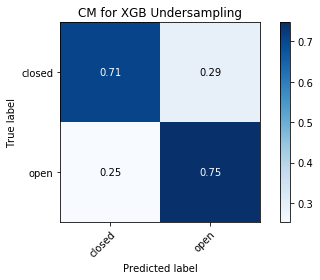

----------


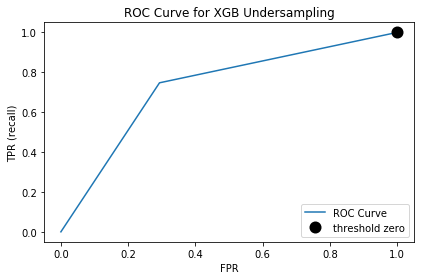

Area Under Curve = 0.7270
----------


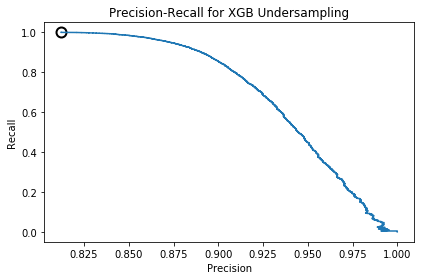

In [6]:
#make pred with undersampling
y_pred_under = xgb_under.predict(X_test)

print(classification_report(y_test, y_pred_under))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, y_pred_under, ['closed', 'open'], normalize=True,
                                title='XGB Undersampling')
print(10*'-')
plot_help.plot_roc_curve(y_test, y_pred_under, 'XGB Undersampling')
print(10*'-')
plot_help.plot_prc_curve(y_test, xgb_under.predict_proba(X_test)[:, 1], 'XGB Undersampling')

In [7]:
feats_df_under = utils.get_top_feat_df(xgb_under.feature_importances_, 
                                       df_num, 
                                       'xgb_undersample')
feats_df_under.head()

,xgb_undersample
Restaurants,0.104320
lunch,0.101355
dinner,0.059586
AcceptsInsurance,0.043206
BikeParking,0.041057


## Oversample

In [8]:
#apply undersampling
X_over, y_over = utils.oversample(X_train, y_train)

#check mean 
y_over.mean()

0.44714800950378614

In [9]:
xgb_over = xgb.XGBClassifier(n_estimators=300,
                              colsample_bytree=0.9, 
                              eta=0.9, 
                              max_depth=6, 
                              num_boost_round=100,
                              subsample=0.9, 
                              n_jobs=-1)

xgb_over.fit(X_over, y_over )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, num_boost_round=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, verbosity=1)

              precision    recall  f1-score   support

           0       0.38      0.74      0.50      6072
           1       0.92      0.72      0.81     26160

    accuracy                           0.72     32232
   macro avg       0.65      0.73      0.66     32232
weighted avg       0.82      0.72      0.75     32232

----------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


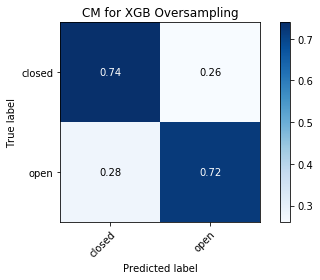

----------


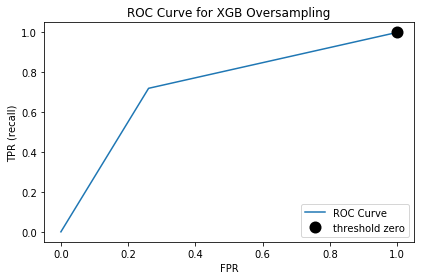

Area Under Curve = 0.7294
----------


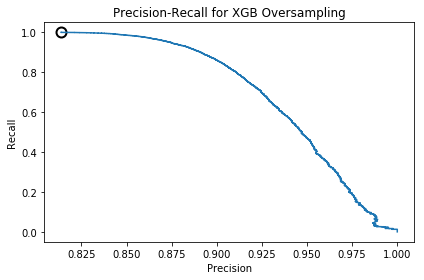

In [10]:
#make pred with undersampling
y_pred_over = xgb_over.predict(X_test)

print(classification_report(y_test, y_pred_over))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, 
                                y_pred_over, 
                                ['closed', 'open'], normalize=True,
                                title='XGB Oversampling')
print(10*'-')
plot_help.plot_roc_curve(y_test, 
                         y_pred_over, 
                         'XGB Oversampling')
print(10*'-')
plot_help.plot_prc_curve(y_test, 
                         xgb_over.predict_proba(X_test)[:, 1], 
                         'XGB Oversampling')

In [11]:
#get top coefficients
feats_df_ovr = utils.get_top_feat_df(xgb_over.feature_importances_, 
                                     df_num, 
                                     'xgb_oversample')
feats_df_ovr.head()

,xgb_oversample
Restaurants,0.125031
lunch,0.110489
dinner,0.051585
AcceptsInsurance,0.048000
BikeParking,0.038656


In [12]:
#note bottom coeffs have 0 weight
feats_df_ovr.tail()

,xgb_oversample
soy_free,0.0
kosher,0.0
curly,0.0
dairy_free,0.0
no_music,0.0


In [13]:
#confirm with minimum
feats_df_ovr.min()

xgb_oversample    0.0
dtype: float32

In [14]:
#sanity check adds up to 1.0
feats_df_ovr.sum()

xgb_oversample    1.0
dtype: float32

## Oversampling With More Data

In [15]:
#change read limit to -1 to load entire dataframe
df_bus_dens = utils.chunk_loader('data/cleaned/business_merge_density_added.csv', read_limit=-1)

df_bus_dens = utils.make_num_df(df_bus_dens)

X_train_dens, X_test_dens, y_train, y_test = utils.train_test_scale (df_bus_dens, 
                                                           'is_open', 
                                                           random_state=None)

#apply oversampling
X_over_dens, y_over = utils.oversample(X_train_dens, y_train)

In [16]:
#reassign new classifier
xgb_over_dens = xgb.XGBClassifier(n_estimators=300,
                              colsample_bytree=0.9, 
                              eta=0.9, 
                              max_depth=6, 
                              num_boost_round=100,
                              subsample=0.9, 
                              n_jobs=-1)

xgb_over_dens.fit(X_over_dens, y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, num_boost_round=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, verbosity=1)

              precision    recall  f1-score   support

           0       0.41      0.74      0.53      6072
           1       0.93      0.75      0.83     26160

    accuracy                           0.75     32232
   macro avg       0.67      0.75      0.68     32232
weighted avg       0.83      0.75      0.77     32232

----------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


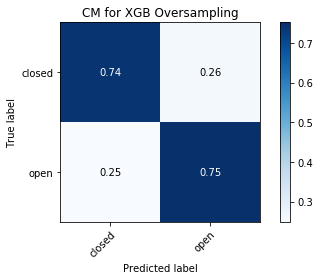

----------


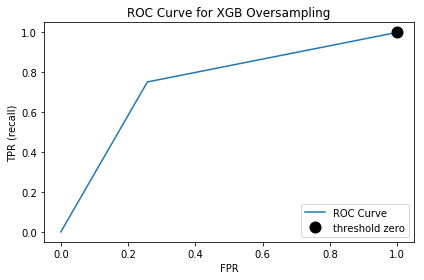

Area Under Curve = 0.7472
----------


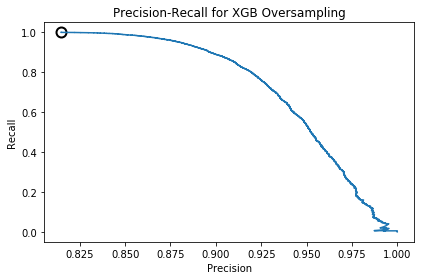

In [17]:
#make pred with undersampling
y_pred_over_dens = xgb_over_dens.predict(X_test_dens)

print(classification_report(y_test, y_pred_over_dens))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, 
                                y_pred_over_dens, 
                                ['closed', 'open'], normalize=True,
                                title='XGB Oversampling')
print(10*'-')
plot_help.plot_roc_curve(y_test, 
                         y_pred_over_dens, 
                         'XGB Oversampling')
print(10*'-')
plot_help.plot_prc_curve(y_test, 
                         xgb_over_dens.predict_proba(X_test_dens)[:, 1], 
                         'XGB Oversampling')

In [18]:
#get top coefficinets
feats_df_dens = utils.get_top_feat_df(xgb_over_dens.feature_importances_, 
                                      df_bus_dens, 
                                      'xgb_oversample_dens')
feats_df_dens.head()

,xgb_oversample_dens
Restaurants,0.108288
lunch,0.089659
dinner,0.056048
RestaurantsPriceRange2,0.053290
chain,0.046459


In [48]:
#save the work
utils.pickle_save(xgb_over_dens, 'models/xgb_over.pickle')

model saved to: models/xgb_over.pickle
